# Unidad Práctica 5 (preliminar): Introducción a la Visualización de Redes

Por **Eduardo Graells-Garrido**. <egraells@udd.cl>. 

Actualizado: **22 de julio de 2022**.

En este notebook aprenderemos a visualizar redes con el módulo `aves` a través de [graphtool](graph-tool.skewed.de/), una biblioteca para trabajar con redes en Python.

Los propósitos de esta clase son los siguientes:

  1. Cargar una red.
  2. Explorar como visualizarla.
  3. Definir una tarea y usar visualización para responderla.
  
Como data set de prueba utilizaremos la Red de Jazz que se encuentra en [Colección de Redes de Koblenz](http://konect.uni-koblenz.de/networks/arenas-jazz). Ya está incluida en el repositorio `aves`, en la carpeta `data/external/arenas-jazz`.


## Google Colab

Para ejecutar este notebook en Colab, primero ejecuten la siguiente celda. Luego el notebook se reiniciará.

In [2]:
try:
    import google.colab
    !pip uninstall matplotlib -y
    !pip install -q condacolab
    
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

Una vez que se ha reiniciado puedes ejecutar el resto de las celdas.

In [3]:
try:
    import google.colab
    !git clone https://github.com/zorzalerrante/aves.git aves_git
    !mamba env update --name base --file aves_git/environment-colab.yml
except ModuleNotFoundError:
    pass

## Preámbulo y Carga de Datos

In [4]:
import sys
from pathlib import Path

AVES_ROOT = Path("..") if not "google.colab" in sys.modules else Path("aves_git")

DATA_PATH = AVES_ROOT / "data" / "external" / "arenas-jazz"
DATA_PATH

PosixPath('../data/external/arenas-jazz')

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 150
# esto depende de las fuentes que tengas instaladas en el sistema.
mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

El dataset que utilizaremos tiene un archivo README que explica su origen y composición. Está en inglés.

In [6]:
!cat {DATA_PATH}/README.arenas-jazz

Jazz musicians network, part of the Koblenz Network Collection

This directory contains the TSV and related files of the arenas-jazz network:

This is the collaboration network between Jazz musicians.  Each node is a Jazz musician and an edge denotes that two musicians have played together in a band.  The data was collected in 2003. 


More information about the network is provided here: 
http://konect.uni-koblenz.de/networks/arenas-jazz

Files: 
    meta.arenas-jazz -- Metadata about the network 
    out.arenas-jazz -- The adjacency matrix of the network in space separated values format, with one edge per line
      The meaning of the columns in out.arenas-jazz are: 
        First column: ID of from node 
        Second column: ID of to node


Complete documentation about the file format can be found in the KONECT
handbook, in the section File Formats, available at:

http://konect.uni-koblenz.de/publications

All files are licensed under a Creative Commons Attribution-ShareAlike 2.0 G

En castellano, dice:

> Esta es una red de colaboración entre músicos y músicas de Jazz. Cada nodo es una persona y una arista implica que dos personas han interpretado música juntes en una banda. Los datos fueron recolectados el año 2003. 

Veamos la cabecera del archivo:

In [7]:
!head {DATA_PATH}/out.arenas-jazz -n 10

% sym unweighted
1	10
1	11
1	12
1	13
1	14
1	15
1	16
1	17
1	18


El archivo que contiene la red tiene dos tipos de líneas:

- La primera, que tiene un comentario. Podemos ignorarlo.
- El resto, donde cada línea representa una arista. En ella aparecen dos números: el identificador del nodo de origen de una arista, y el identificador del nodo de destino de la misma arista.

Podemos usar `pandas` para cargar el archivo sin problemas.

In [8]:
edgelist = pd.read_csv(
    # ruta al archivo
    f"{DATA_PATH}/out.arenas-jazz",
    # noten que está separado por TABS, no por comas
    sep="\t",
    # no leer la primera línea
    skiprows=1,
    # no tiene nombres de columnas
    header=0,
    # estos son los nombres de las columnas
    names=["source", "target"],
)

edgelist


source  target
0          1      11
1          1      12
2          1      13
3          1      14
4          1      15
...      ...     ...
2736     185     186
2737     187     188
2738     187     189
2739     188     189
2740     193     194

[2741 rows x 2 columns]

En aves la clase `Network` nos permite crear una red a partir de una tabla de aristas. Notemos que esta es una red no dirigida, es decir, las aristas no tienen dirección, se pueden interpretar en cualquier dirección: si A colabora con B, B también colabora con A.

In [9]:
from aves.models.network import Network

network = Network.from_edgelist(edgelist, directed=False)
network.num_vertices, network.num_edges


(198, 2741)

La visualización `NodeLink` se construye a partir del modelo `Network`:

In [10]:
from aves.visualization.networks import NodeLink

# creación
nodelink = NodeLink(network)

# organización de los noodos
nodelink.layout_nodes()

# el tamaño de un nodo será proporcional a la cantidad de conexiones que tenga
nodelink.set_node_drawing(method="plain", weights="total_degree")

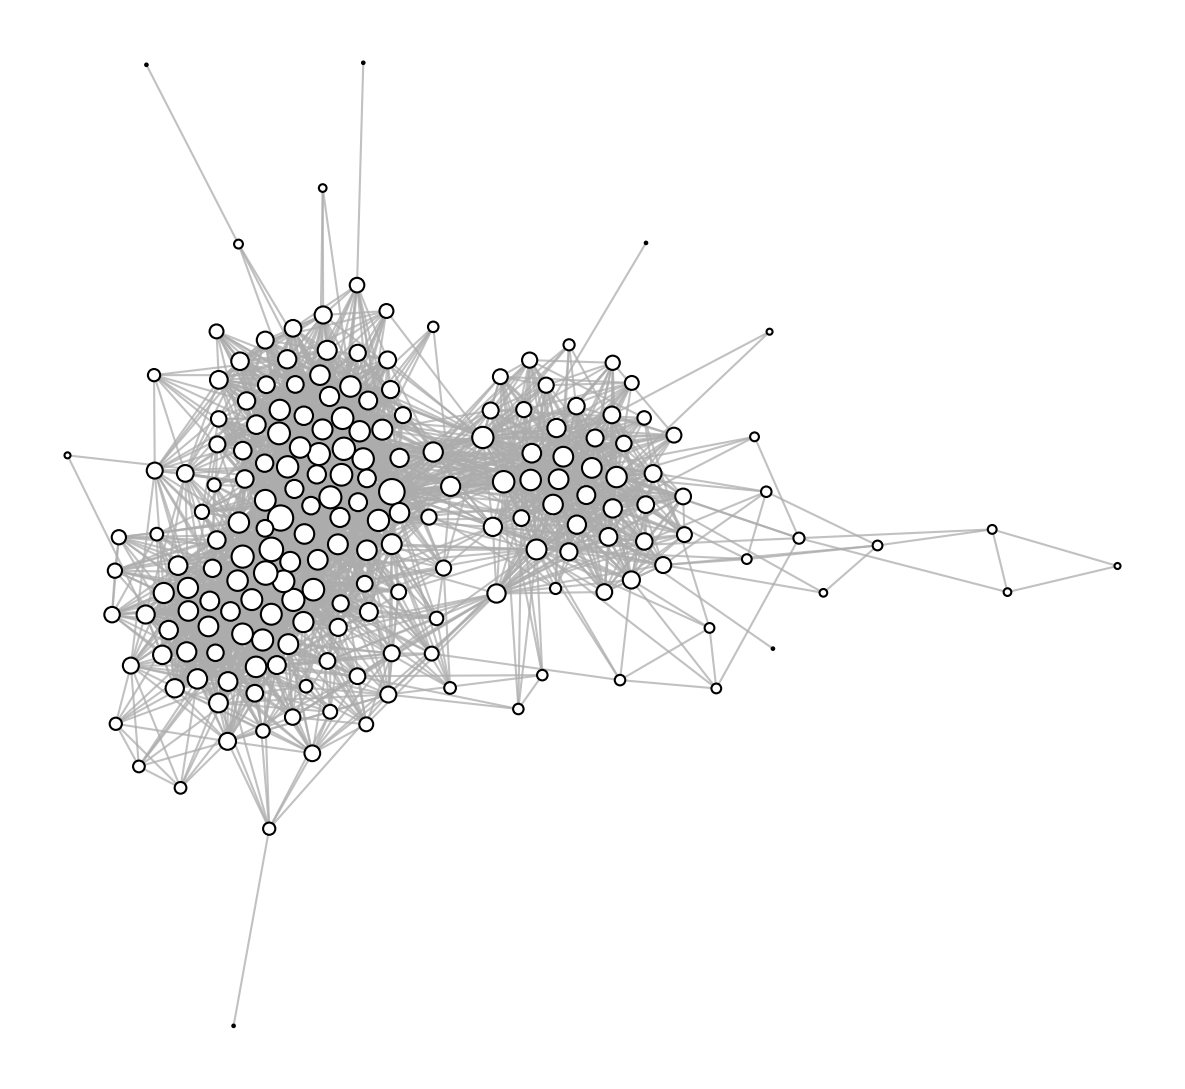

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

# el tamaño del nodo es proporcinoal a las conexiones.
# el parámetro node_size es el tamaño máximo.
nodelink.plot(ax, nodes=dict(node_size=150, facecolor="white", edgecolor="black", linewidth=1))

ax.set_axis_off()
ax.set_aspect("equal")
fig.tight_layout()

# fig.savefig('../reports/figures/example_nodelink.png')


También podemos configurar la apariencia de las aristas. Ya que no son dirigidas ni tienen peso, debemos asignarles uno. Una manera común de hacerlo es a través de la [centralidad](https://en.wikipedia.org/wiki/Betweenness_centrality):

In [12]:
nodelink.set_edge_drawing(method="weighted", weights='betweenness', k=20)


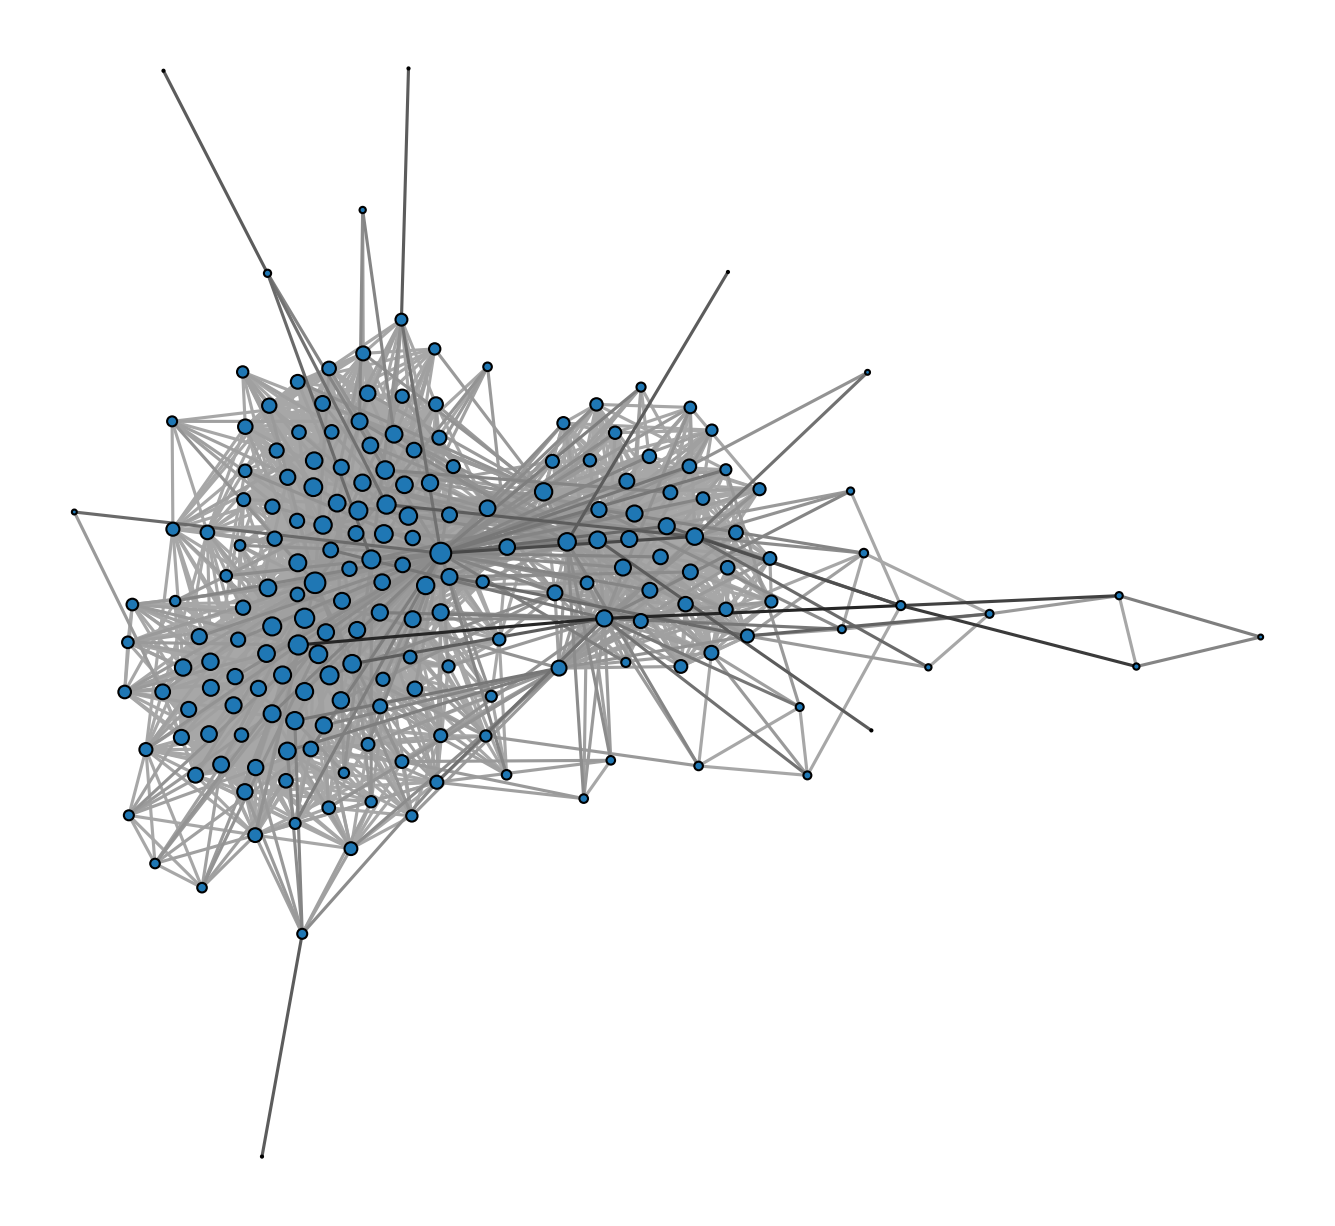

In [13]:
fig, ax = plt.subplots(figsize=(9, 9))

nodelink.plot(ax, nodes=dict(node_size=100, edgecolor="black", linewidth=1))

ax.set_axis_off()
ax.set_aspect("equal")
fig.tight_layout()


Pongamos atención a lo siguiente:

1. Cuando cargamos la red, en ningún momento especificamos una posición `(x, y)` para cada nodo de la red.
2. Al visualizar la red, esas posiciones tienen que salir de algún método.
  
El método que genera las posiciones es un _algoritmo de organización_ (_layout algorithm_). Estos algoritmos posicionan los nodos en la imagen, y algunos utilizan números aleatorios para encontrar buenas posiciones de los nodos. Al ser un proceso que se ejecuta cada vez que dibujamos la red, el resultado es distinto. 

Distinto, pero _similar_: el algoritmo tiende a hacer lo mismo.

Primero probamos el método `sfdp`. Ahora veamos el método `arf`:

In [14]:
nodelink.layout_nodes(method="force-directed", algorithm="arf")


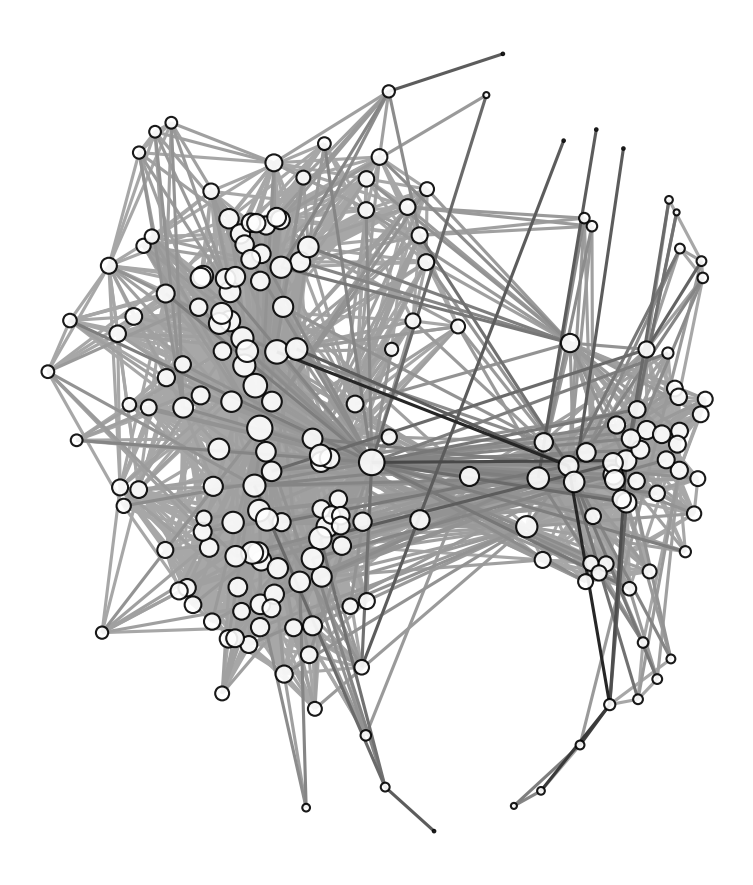

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))

nodelink.plot(ax, nodes=dict(node_size=150, facecolor="white", edgecolor="black", linewidth=1, alpha=0.9))

ax.set_axis_off()
ax.set_aspect("equal")
fig.tight_layout()


## Estimar y Visualizar Caminos en la Red

Una tarea común es **visualizar los caminos en una red**. Por ejemplo, cada vez que pides instrucciones o caminos en una aplicación de mapas, estás observando el resultado de una estimación de caminos en la red (usualmente el camino más corto, _shortest path_). La diferencia es que en los mapas el territorio define la organización.

En el caso de una red de colaboración, una posible interpretación de un camino más corto es la secuencia de personas a las que debes contactar para conocer a alguien específico.

Veamos como graficar caminos entre dos nodos aleatorios en la red.
Para ello, importaremos el módulo `random`:

In [16]:
import random 

src = random.randint(1, network.num_vertices)
dst = random.randint(1, network.num_vertices)

src, dst

(166, 16)

El método `shortest_path` entrega la secuencia de nodos para ir desde un nodo origen hasta un nodo destino:

In [17]:
shortest_paths = network.shortest_path(src, dst)
shortest_paths

[[166, 18, 16], [166, 21, 16], [166, 23, 16], [166, 4, 16]]

Para graficar un camino (el primero que se haya encontrado) crearemos una vista parcial de la red que solo contenga los nodos correspondientes:

In [18]:
view = network.subgraph(shortest_paths[0])
view.num_vertices, view.num_edges

(3, 2)

In [19]:
nodelink_view = NodeLink(view)
nodelink_view.set_edge_drawing(method="plain")

In [20]:
nodelink_view.set_node_drawing(method='labeled')

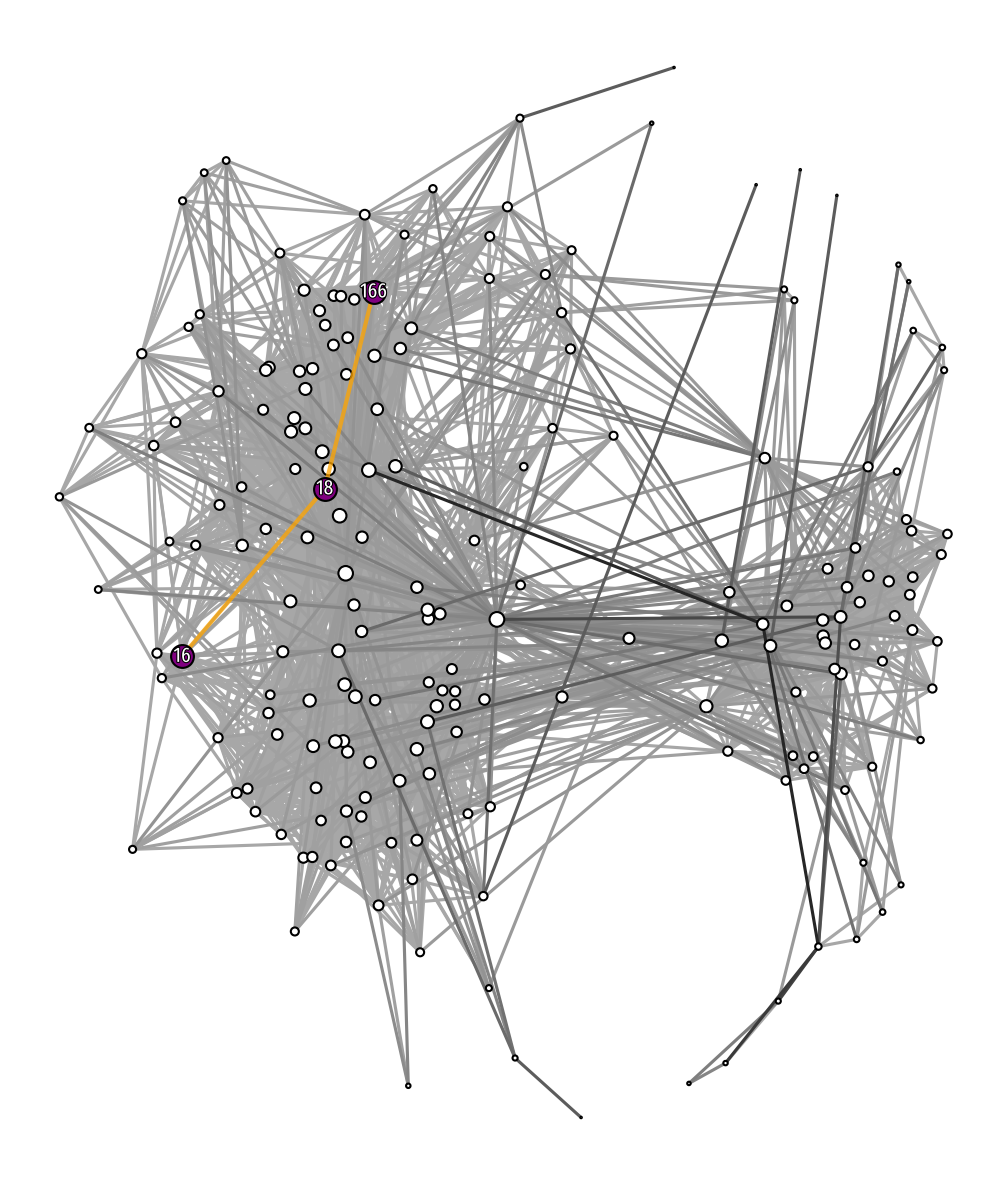

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

# full network
nodelink.plot(ax, nodes=dict(node_size=50, color="white", edgecolor="black"))

# shortest path with highlights
nodelink_view.plot(
    ax,
    edges=dict(color="orange", linewidth=2),
    nodes=dict(node_size=120, color="purple", edgecolor="black"),
)

ax.set_axis_off()
ax.set_aspect("equal")
fig.tight_layout()


In [22]:
network.detect_communities()

In [23]:
nodelink.set_node_drawing(
    # peso de los nodos
    weights='total_degree',
    # categorías a utilizar para colorear los nodos. pueden ser las mismas de HEB
    categories='community',
)

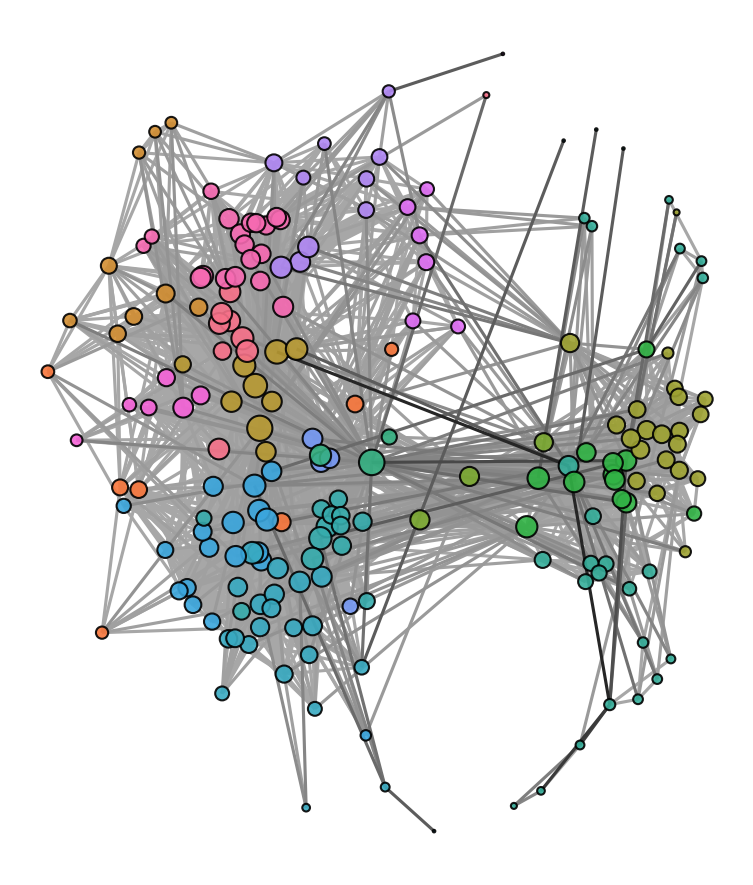

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))

nodelink.plot(ax, nodes=dict(node_size=150, facecolor="white", edgecolor="black", linewidth=1, alpha=0.9, palette='husl'))

ax.set_axis_off()
ax.set_aspect("equal")
fig.tight_layout()

Como vemos, tenemos una noción de dónde está cada uno de los nodos involucrados en la red, e incluso podemos ver que al parecer el camino cruza desde una comunidad a otra.

Ahora bien, debemos tener cuidado al interpretar una visualización como ésta: el algoritmo de organización tiene un criterio gráfico para posicionar nodos en la imagen, una comunidad o _cluster_ en la visualización no necesariamente representa un _cluster real en la estructura_.

## Tarea: Detección de Comunidades

Una tarea común en el análisis de redes es encontrar comunidades de nodos, es decir, grupos que estén altamente conectados entre sí en comparación con las conexiones de los demás nodos. A veces estamos interesados en el comportamiento colectivo de la red, y en ese caso, podríamos analizar los patrones de comportamiento de las comunidades en vez de los de cada nodo.

En nuestro data set, la visualización sugiere que hay al menos dos comunidades. Quizás hay más. No lo sabemos aún. Pero, ¿cuál es el significado de comunidad aquí? El data set es sobre músicos de jazz que interpretan música juntos. Entonces, quizás cada comunidad se refiere a estilos específicos de interpretación, a variaciones del jazz, a ubicaciones en las que tocan música, etc.


Los nodos que están en los bordes del círculo son los músicos, y los nodos interiores son las comunidades.

Noten como los nodos están ordenados de acuerdo a las comunidades. El nodo central es una raíz artificial que agregamos en nuestra magia negra, que nos permitió darle la estructura de árbol a la red total.

El siguiente paso es generar el diccionario de posiciones solamente para los nodos de nuestra red original:

In [25]:
network.detect_communities(method='hierarchical')

In [26]:
from cytoolz import valmap
import numpy as np
valmap(lambda x: np.unique(x), network.communities_per_level)

{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 

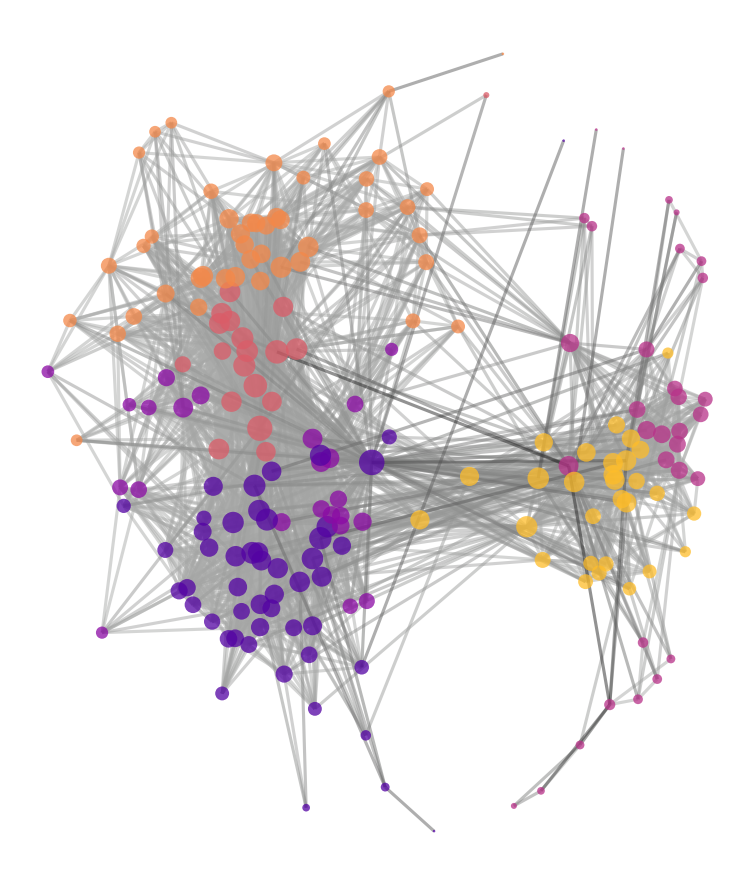

In [27]:
network.set_community_level(2)
nodelink.set_node_drawing(
    "plain",
    weights="total_degree",
    # categorías a utilizar para colorear los nodos. pueden ser las mismas de HEB
    categories='community',
)

fig, ax = plt.subplots(figsize=(6, 6))

nodelink.plot(ax, 
    nodes=dict(node_size=150, palette='plasma', edgecolor='none', alpha=0.75), 
    edges=dict(color='#abacab', alpha=0.5))


ax.set_axis_off()
ax.set_aspect('equal')
fig.tight_layout()

In [28]:
heb = nodelink.bundle_edges(method="hierarchical")

In [29]:
network.set_community_level(2)
nodelink.set_node_drawing(
    # muestra las etiquetas
    "labeled",
    # como el método HEB es radial, podemos aprovechar eso para orientar el texto (rotarlo)
    radial=True,
    # distancia radial desde los nodos
    offset=0.1,
    # peso de los nodos
    weights="total_degree",
    # categorías a utilizar para colorear los nodos. pueden ser las mismas de HEB
    categories='community',
)


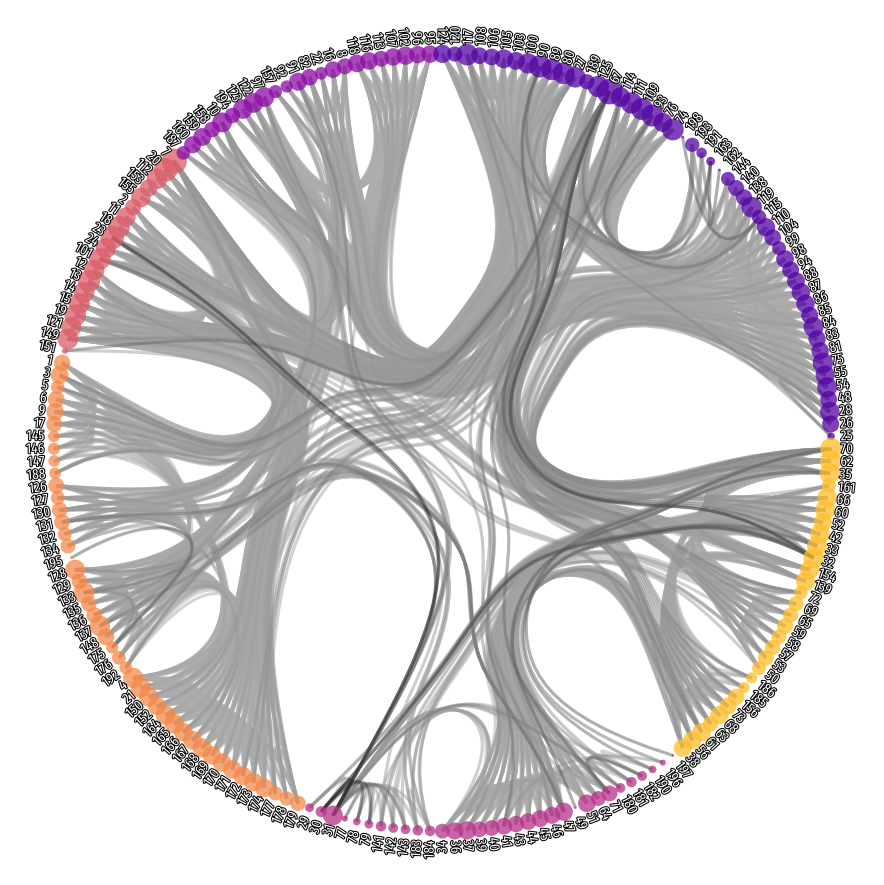

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))

nodelink.plot(ax, 
    nodes=dict(node_size=150, palette='plasma', edgecolor='none', alpha=0.75, fontsize='x-small'), 
    edges=dict(color='#abacab', alpha=0.5))


ax.set_axis_off()
ax.set_aspect('equal')
fig.tight_layout()

Podemos visualizar la estructura de HEB para entender lo que hace este método:

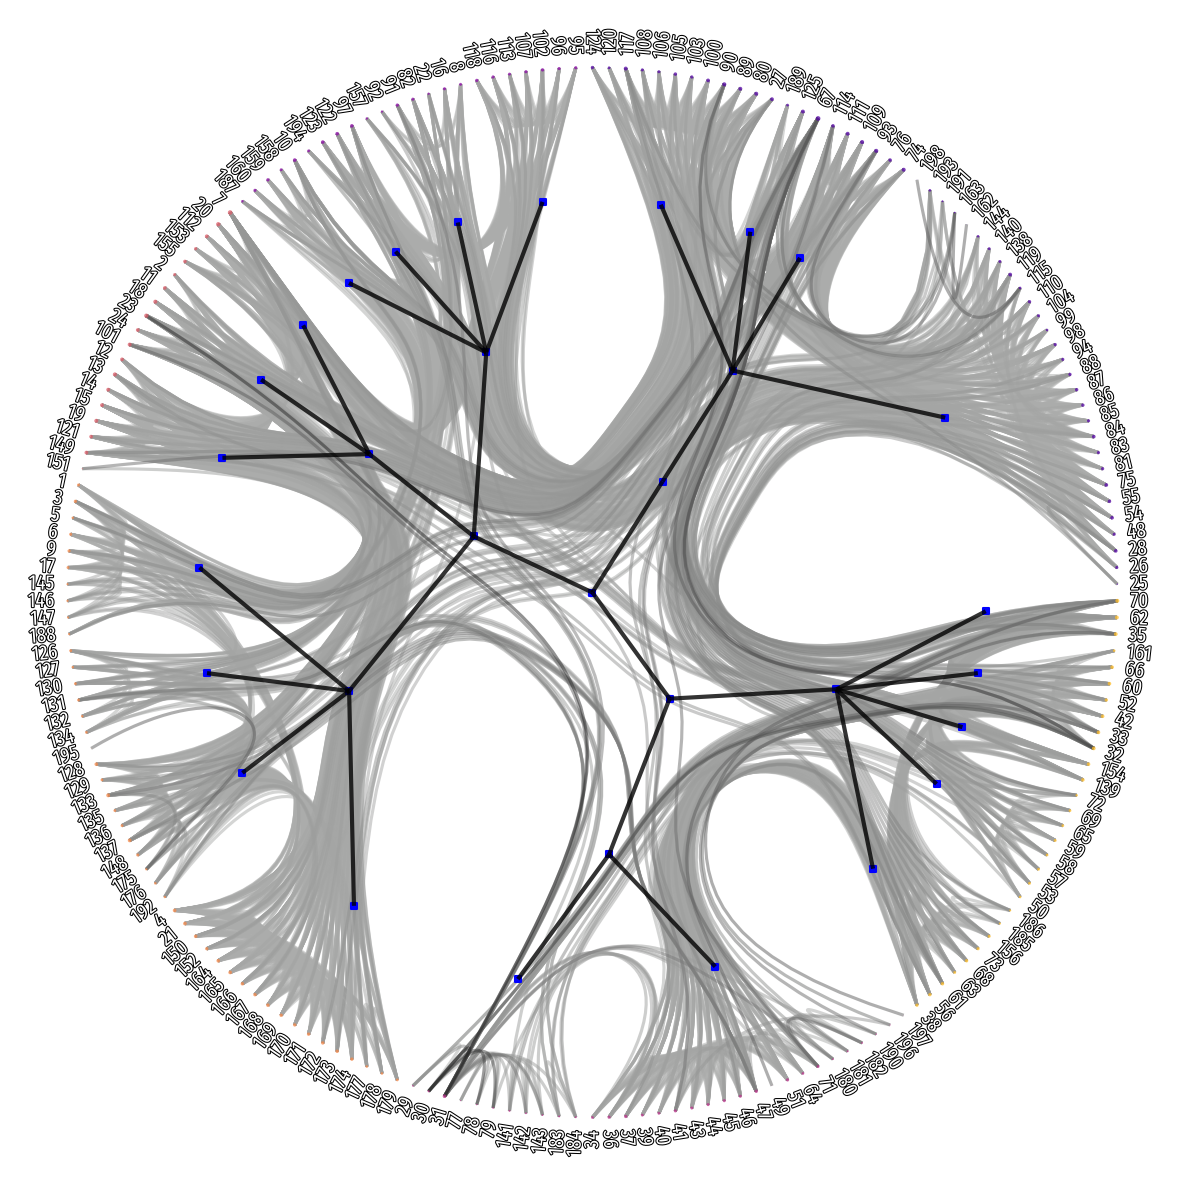

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

nodelink.plot(
    ax,
    nodes=dict(
        node_size=5, palette="plasma", edgecolor="none", alpha=0.75),
    edges=dict(color="#abacab", alpha=0.5),
)

heb.plot_community_network(ax)

ax.set_axis_off()
ax.set_aspect("equal")
fig.tight_layout()


Increíble, ¿no? Ahora podemos ver como las comunidades se conectan entre sí y también como los miembros de una comunidad se relacionan. Vemos quienes son populares y quienes son puentes con otras comunidades. Piensen en lo útil que podría ser esto para un agente artístico.

Podemos utilizar la categorización para colorear las aristas:

In [32]:
network.set_community_level(3)
nodelink.set_node_drawing(
    # muestra las etiquetas
    "labeled",
    # como el método HEB es radial, podemos aprovechar eso para orientar el texto (rotarlo)
    radial=True,
    # distancia radial desde los nodos
    offset=0.1,
    # peso de los nodos
    weights='pagerank',
    # categorías a utilizar para colorear los nodos. pueden ser las mismas de HEB
    categories='community',
)

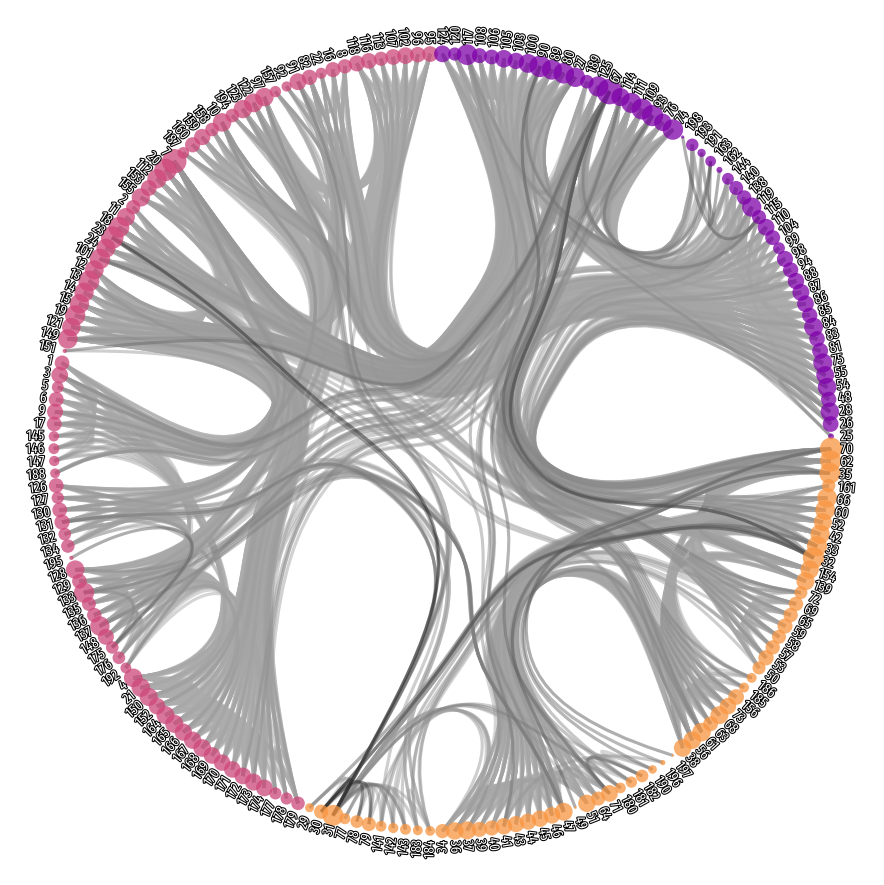

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))

nodelink.plot(ax, 
    nodes=dict(node_size=150, palette='plasma', edgecolor='none', alpha=0.75, fontsize='x-small'), 
    edges=dict(color='#abacab', alpha=0.5))


ax.set_axis_off()
ax.set_aspect('equal')
fig.tight_layout()

In [34]:
nodelink.set_edge_drawing(
    "community-gradient", level=3
)


In [35]:
nodelink.set_node_drawing(
    # muestra las etiquetas
    "plain",
    # como el método HEB es radial, podemos aprovechar eso para orientar el texto (rotarlo)
    radial=True,
    # distancia radial desde los nodos
    offset=0.1,
    # peso de los nodos
    weights="total_degree",
    # categorías a utilizar para colorear los nodos. pueden ser las mismas de HEB
    categories='community',
)

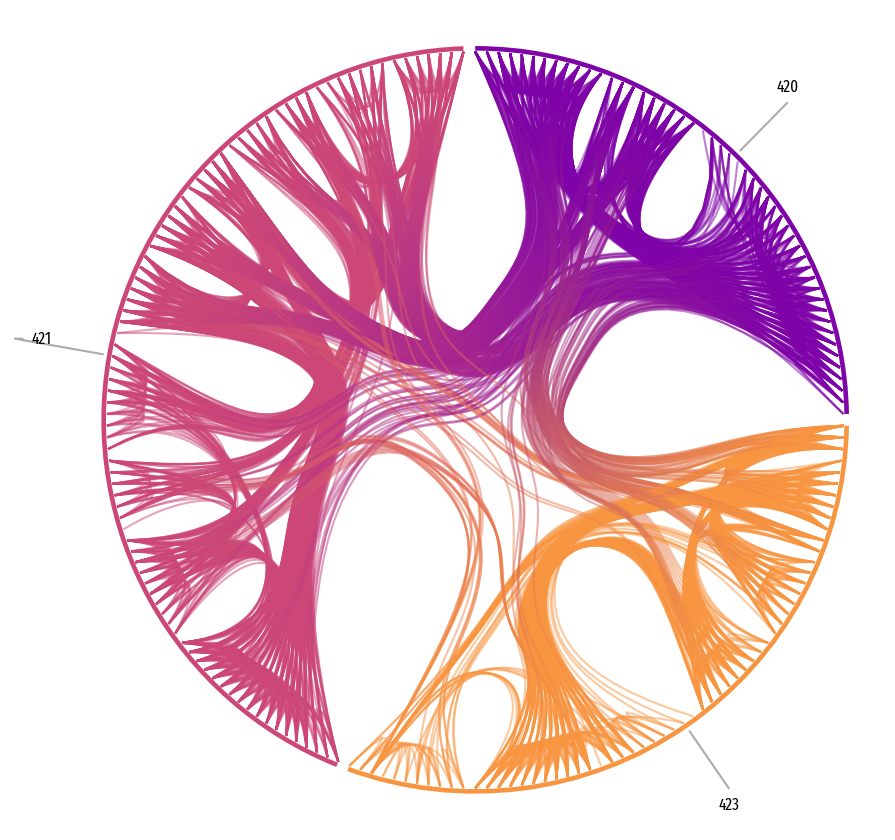

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))

# necesitamos graficar los nodos para ajustar los límites de la visualización.
nodelink.plot_nodes(ax, alpha=0)

nodelink.plot_edges(ax, alpha=0.5)

# aquí podríamos tener una función que tome el identificador de la comunidad y 
# genere un texto para desplegar como nombre.
nodelink.bundle_model.plot_community_wedges(
    ax, wedge_width=0.05, level=3, wedge_offset=0.01, label_func=lambda x: x, palette="plasma"
)

ax.set_axis_off()
ax.set_aspect("equal")
fig.tight_layout()

# fig.savefig('../reports/figures/example_heb.png')


Ahora bien, en Hierarchical Edge Bundling las comunidades también dependen de la inicialización del algoritmo, que utiliza números generados aleatoriamente. En un análisis riguroso, el procedimiento es repetir el proceso varias veces (decenas o incluso cientos de veces), y luego utilizar un método que permita saber cuál es el modelo que presenta mejor ajuste. En el caso de `graph_tool`, esto se hace [eligiendo el modelo que genera la descripción más compacta de la red](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#the-stochastic-block-model-sbm).

Con esto terminamos esta clase.

La visualización de redes permite estudiar los datos a traves de las relaciones presentes en ellos, lo que la vuelve un buen complemento para las otras técnicas que hemos trabajado en el curso.

In [37]:
network.save('test.gt')

In [38]:
test_network = Network.load('test.gt')

In [39]:
test_nodelink = NodeLink(test_network)

In [40]:
test_nodelink.bundle_edges(method='hierarchical')

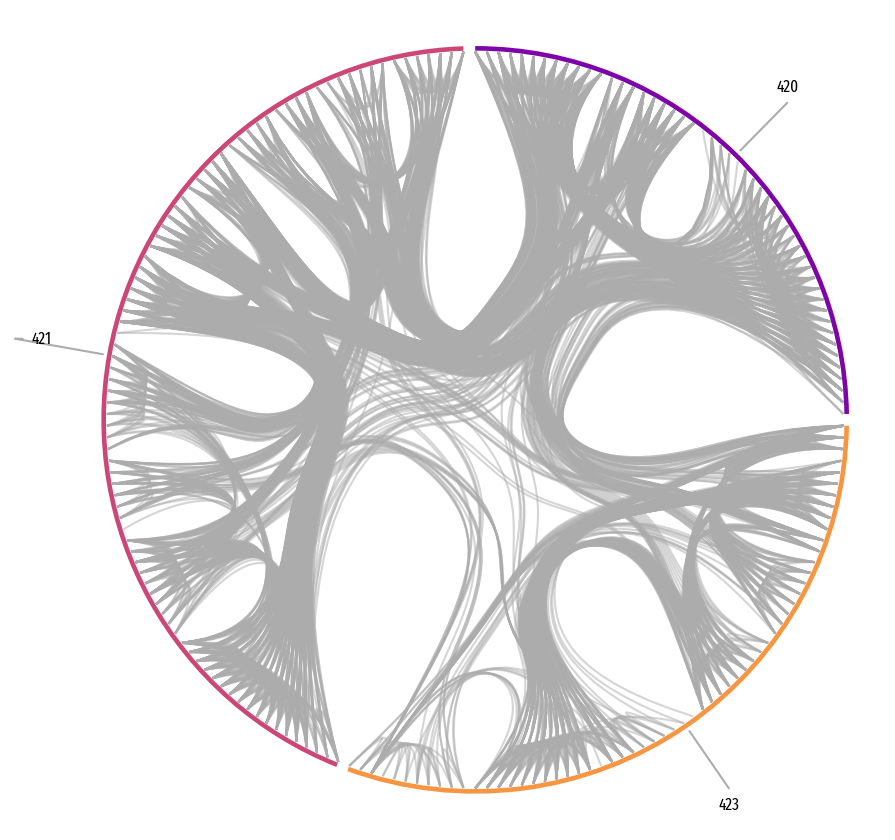

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))

# necesitamos graficar los nodos para ajustar los límites de la visualización.
test_nodelink.plot_nodes(ax, alpha=0)

test_nodelink.plot_edges(ax, alpha=0.5)

# aquí podríamos tener una función que tome el identificador de la comunidad y 
# genere un texto para desplegar como nombre.
test_nodelink.bundle_model.plot_community_wedges(
    ax, wedge_width=0.05, level=3, wedge_offset=0.01, label_func=lambda x: x, palette="plasma"
)

ax.set_axis_off()
ax.set_aspect("equal")
fig.tight_layout()
